# 综述


_由于有一些星表中包含缺省项，我们需要使用pandas中使用dataframe读取csv中自动将缺省项补上的优势，来优化我们的自动化程式_


我们需要实现的功能包含以下几点：

输入：
* csv星表**_的名字_**
* 需要画的色指数的两个测光点（比如 $ J - H $ 我们需要输入$J$ 和 $H$）

程序中自带（我们所需要限定的条件）
_写在其中的某一个cell中作为 filt 条件_
* 限定的误差范围（看各波段误差分布，取符合统计规律的限定）
* 去掉错误的点（见之前的程序)

操作：
* 蓝边缘选取（根据误差选择选取前%？的源，以及三sigema剔除）
* 对所有点算SFD,选取<0.05的源认为它没有消光
* 对蓝边缘点和SFD无消光点作拟合（拟合函数及方法暂定）

输出：
* 颜色-teff 图（其中包括全部数据点，蓝边缘点，SFD<0.05的点 ， parsec点，以及拟合曲线）



# 数据的引入和format (Alternative)

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import datetime
from scipy.optimize import curve_fit
%matplotlib inline

data_dir = '/Users/SY/Desktop/obic/data/'
#data_dir = '/Users/dengdingshan/Documents/data/obic/'

In [16]:
#read as pandas
# starcatalog_fram = pd.read_csv(data_dir + 'LMOB-V4-SFDGP-right_panstar.csv') 
starcatalog_fram = pd.read_csv(data_dir + 'lamost_obastars_8000_2mass.csv')

###########
starcatalog_fram.columns
#print(starcatalog_fram)

Index(['col1', 'Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'TEFF',
       'ERR_TEFF', 'RA', 'DEC', 'LOGG', 'ERR_LOGG', 'FEH', 'ERR_FEH',
       'SFD_ebv', 'l', 'b', '2MASS', 'RAJ2000', 'DEJ2000', 'errHalfMaj',
       'errHalfMin', 'errPosAng', 'Jmag', 'Hmag', 'Kmag', 'e_Jmag', 'e_Hmag',
       'e_Kmag', 'Qfl', 'Rfl', 'X', 'MeasureJD', 'angDist'],
      dtype='object')

In [17]:
# fill the NaN blocks with 0

starcatalog_fram_fil0 = starcatalog_fram.fillna(0)

In [18]:
#read parsec
parsec_fram = pd.read_csv(data_dir + 'parsec-2MASS-WISE.csv') #PARSEC2MASSandWISEMinus PARSECGALEXandSDSSPlus

############

print(parsec_fram.columns)

Index(['Zini', 'Age', 'Mini', 'Mass', 'logL', 'logTe', 'logg', 'label',
       'McoreTP', 'C_O', 'period0', 'period1', 'pmode', 'Mloss', 'tau1m', 'X',
       'Y', 'Xc', 'Xn', 'Xo', 'Cexcess', 'Z', 'mbolmag', 'Jmag', 'Hmag',
       'Ksmag', 'IRAC_3.6mag', 'IRAC_4.5mag', 'IRAC_5.8mag', 'IRAC_8.0mag',
       'MIPS_24mag', 'MIPS_70mag', 'MIPS_160mag', 'W1mag', 'W2mag', 'W3mag',
       'W4mag'],
      dtype='object')


## 所需参数的选取（Input）

In [69]:
### variables

teff = 'TEFF'

color1 = 'Hmag'
color2 = 'Kmag'
err_teff = 'ERR_TEFF'

err_c1 ='e_' + color1
#'e_' + color1
#color1 + 'err' 
#color1 + 'err'
#'ERR_' + color1
#'e_' + color1

err_c2 ='e_' + color2
#'ERR_' + color2
#'e_' + color2

## Logg选取(Input:)

In [70]:
### we just need the mainsquence (dwarf stars)

# #judge logg >3.0

Judge_logg = 3.5

starcatalog_fram_fil = starcatalog_fram_fil0[(starcatalog_fram_fil0['LOGG']> Judge_logg)]
parsec_fram = parsec_fram[(parsec_fram['logg']>Judge_logg)]                                            

## 测光误差的选取(input:)

In [71]:
### get the good stars

# judge  data
starcatalog_fram_fil=starcatalog_fram_fil[((starcatalog_fram_fil[err_c1] != 0) \
                                          & (starcatalog_fram_fil[err_c2] != 0)\
                                          & (starcatalog_fram_fil[err_c1] > -99) \
                                          & (starcatalog_fram_fil[err_c2] > -99))\
                                         & ((starcatalog_fram_fil[color1] != 0)\
                                           & (starcatalog_fram_fil[color2] != 0)\
                                           & (starcatalog_fram_fil[color1] != -99) \
                                           & (starcatalog_fram_fil[color2] != -99))\
                                         &((starcatalog_fram_fil[err_c1] <=0.03))
                                          & ((starcatalog_fram_fil[err_c2] <=0.03))]
#saturated magnitude

if (color1=='J' or color2=='J'):
     starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['J'] >= 5.5)]
if (color1=='H' or color2=='H'):
     starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['H'] >= 5)]  
if (color1=='KS' or color2=='KS'):
     starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['KS'] >= 4.5)]
if (color1=='W1' or color2=='W1'):
     starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['W1'] >= 8.1)]
if (color1=='W2' or color2=='W2'):
     starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['W2'] >= 6.7)]  
if (color1=='W3' or color2=='W3'):
     starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['W3'] >= 3.8)]

# if (color1=='gmag' or color2=='gmag'):
#      starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['gmag'] >= 14)]
# if (color1=='rmag' or color2=='rmag'):
#      starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['rmag'] >= 14)]
# if (color1=='imag' or color2=='imag'):
#      starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['imag'] >= 13)]
# if (color1=='zmag' or color2=='zmag'):
#      starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['zmag'] >= 13)]
# if (color1=='ymag' or color2=='ymag'):
#      starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['ymag'] >= 13)]
        

# if (color1=='gmag' or color2=='gmag'):
#      starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['gmag'] >= 12)]
# if (color1=='rmag' or color2=='rmag'):
#      starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['rmag'] >= 12)]
# if (color1=='imag' or color2=='imag'):
#      starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['imag'] >= 12)]
# if (color1=='zmag' or color2=='zmag'):
#      starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['zmag'] >= 12)]
# if (color1=='ymag' or color2=='ymag'):
#      starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil['ymag'] >= 12)]

## （金属丰度选取）(input:)

In [72]:
#FEH
# starcatalog_fram_fil=starcatalog_fram_fil[starcatalog_fram_fil['FEH'] > 0] # > <

## 有效温度及其误差选取(input:)

In [73]:
#USE goodOB 
teff_min=np.min(starcatalog_fram_fil['TEFF']) #10000
teff_max=np.max(np.max(starcatalog_fram_fil['TEFF'])) #16000

starcatalog_fram_fil=starcatalog_fram_fil[(((starcatalog_fram_fil[err_teff] != 0 )\
                                          & (starcatalog_fram_fil[teff]>= teff_min)\
                                          & (starcatalog_fram_fil[teff]<= teff_max))\
                                          & (((starcatalog_fram_fil[err_teff]< 600)\
                                          &(starcatalog_fram_fil[teff]> 9000))\
                                          |((starcatalog_fram_fil[err_teff]< 500)\
                                          & (starcatalog_fram_fil[teff]<= 9000))))]
print('max_teff:',teff_max)
print('min_teff:',teff_min)
print('the amount of available sources:',starcatalog_fram_fil.iloc[:,0].size)

max_teff: 9999.69
min_teff: 8000.0137
the amount of available sources: 82939


## 蓝边缘的参数选取(input:)

In [74]:
# Ratio of the bluest edge, usually 5% 前%多少的源
rat = 5

# Low end criteria. If the number in a bin is lower than this number then neglect.  #为保证统计的可靠性，每个区间最少的源为50
low_crit = 50

#the start teff 选取最低温度
teff_start= teff_min

#the pace of slide 滑动窗口的步长
slide_index = 100 



## parsec星表参数的选取(input:)

In [75]:
# parsec point  #16000:4.204 23000:4.362 选取温度范围
parsecframe = parsec_fram[((parsec_fram['logTe'] >= 3.903)\
                           &(parsec_fram['logTe'] < 4))]

#the width of bin
bin_width_parsec = 200 #选取500一个bin

#确定开始和结束的温度
teff_start_parsec = teff_min
teff_end_parsec = teff_max

                                         

In [76]:
parseccolor1 = 'Hmag'
parseccolor2 = 'Ksmag'
color_total = []
teff_total = []
#算色指数
for i in range(int((teff_end_parsec-teff_start_parsec)/bin_width_parsec)):
    parsecframe_bin = parsecframe[( (teff_start_parsec+i*bin_width_parsec) <=10**parsecframe['logTe']) & \
                (10**parsecframe['logTe']< (teff_start_parsec+ (i+1)*bin_width_parsec) )]
    color_total.append(np.median(np.array(parsecframe_bin[parseccolor1]-parsecframe_bin[parseccolor2])))#'Ksmag''NUVmag'
    teff_total.append(teff_start_parsec+(i+0.5)*bin_width_parsec)#选取bin中间温度为蓝边缘点的温度
    
parsec_color = np.array(color_total)
parsec_teff = np.array(teff_total)

# 内禀色指数的计算（蓝色边缘方法），同时取出某一部分用于SFD判断

## DEF

In [77]:
def data(teff_start,ratio,low_crit,ratio_SFD,slide_index):
    
    start_time = time.time()
    int_teff = []
    int_color = []
    bin_int_color = []
    
    SFD_RA = []; SFD_DEC = []; SFD_TEFF = []; SFD_color1 = []; SFD_color2 = [];SFD_ebv = []
    
    data_final = pd.DataFrame(columns=[teff,color1,color2])
    teff_judge = teff_start
    while teff_judge < np.max(starcatalog_fram_fil[teff]) - 200:
        #print(teff_judge)
        if teff_judge <11000:
            bin_width = 100
        else:
            bin_width = 600

        bin_tbl =starcatalog_fram_fil[np.logical_and(starcatalog_fram_fil[teff] > teff_judge, \
                                                starcatalog_fram_fil[teff] < teff_judge+bin_width)]

        #print(teff_judge)
       
        
        if len(bin_tbl) < low_crit:
            teff_judge = teff_judge+slide_index
            continue
            
        source_num = 0
        #print(len(bin_tbl))

        while source_num != len(bin_tbl):
            source_num = len(bin_tbl)

        data_final = data_final.append(bin_tbl[[teff,color1,color2]])
        #print(len(bin_tbl))

        int_teff.append(float(teff_judge+bin_width/2))
        bin_tbl['color'] = bin_tbl[color1]-bin_tbl[color2]
        bin_sort = bin_tbl.sort_index(axis = 0,ascending = True,by = 'color')
        
        # 每个bin中前ratio_SFD的部分用于取得ebv
        color_SFD = bin_sort['color'].values[:math.ceil(len(bin_tbl)*ratio_SFD/100)]
        bin_tbl_SFD = bin_sort[(bin_sort['color']<=np.max(color_SFD))]
        
        for ppp in range(len(bin_tbl_SFD)):
            SFD_RA.append(bin_tbl_SFD['RA'].values[ppp])
            SFD_DEC.append(bin_tbl_SFD['DEC'].values[ppp])
            SFD_TEFF.append(bin_tbl_SFD['TEFF'].values[ppp])
            SFD_color1.append(bin_tbl_SFD[color1].values[ppp])
            SFD_color2.append(bin_tbl_SFD[color2].values[ppp])
            SFD_ebv.append(bin_tbl_SFD['SFD_ebv'].values[ppp])
        
        # 每个bin中前ratio(usually 5%)的部分 用于取得内禀色指数int_color
        color5 = bin_sort['color'].values[:math.ceil(len(bin_tbl)*ratio/100)]
        bin_tbl_5 = bin_sort[(bin_sort['color']<=np.max(color5))]
        
        
        if len(color5) != 0:
            for i in range(20):
                bin_mean = np.median(color5)
                bin_sigma = np.std(color5)
                bin_int_color = color5\
                [((color5<= bin_mean+3*bin_sigma)\
                & (color5>= bin_mean-3*bin_sigma))]
                color5 = np.array(bin_int_color)
                print(bin_mean-3*bin_sigma)
                print(np.min(color5))

            int_color.append(np.median(bin_int_color))
            
        teff_judge = teff_judge+slide_index
        
    SFD_tbl_final = pd.DataFrame({'TEFF':np.array(SFD_TEFF),'RA':np.array(SFD_RA),\
                                  'DEC':np.array(SFD_DEC),color1:np.array(SFD_color1),\
                                 color2:np.array(SFD_color2),'SFD_ebv':np.array(SFD_ebv)})
    
    #print(time.time() - start_time)
    print('int_Teff:',int_teff)
    print(' ') #让底下显示好看一些
    print('int_color:',int_color)
#     print(bin_mean)
#     print(data_final.iloc[:,0].size)
    return int_teff,int_color,data_final,SFD_tbl_final

## 运算，SFD的准备（Input:)

In [78]:
# SFD ratio 需要计算SFD的比例，目前是全部计算

ratio_SFD = 100

# fitting curve
int_teff,int_color,data_final,SFD_tbl_ratio = data(teff_start,rat,low_crit,ratio_SFD,slide_index)



/Users/SY/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/SY/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


-0.0399788546056
-0.038
-0.0331937532542
-0.033
-0.0303470443992
-0.03
-0.0295603039648
-0.029
-0.0293385227715
-0.029
-0.0293385227715
-0.029
-0.0293385227715
-0.029
-0.0293385227715
-0.029
-0.0293385227715
-0.029
-0.0293385227715
-0.029
-0.0293385227715
-0.029
-0.0293385227715
-0.029
-0.0293385227715
-0.029
-0.0293385227715
-0.029
-0.0293385227715
-0.029
-0.0293385227715
-0.029
-0.0293385227715
-0.029
-0.0293385227715
-0.029
-0.0293385227715
-0.029
-0.0293385227715
-0.029
-0.0434925628298
-0.042
-0.0335168822788
-0.033
-0.0303770223272
-0.03
-0.0285283043739
-0.028
-0.0275322441211
-0.027
-0.0265981873112
-0.026
-0.0263946258894
-0.026
-0.0263946258894
-0.026
-0.0263946258894
-0.026
-0.0263946258894
-0.026
-0.0263946258894
-0.026
-0.0263946258894
-0.026
-0.0263946258894
-0.026
-0.0263946258894
-0.026
-0.0263946258894
-0.026
-0.0263946258894
-0.026
-0.0263946258894
-0.026
-0.0263946258894
-0.026
-0.0263946258894
-0.026
-0.0263946258894
-0.026
-0.0440335230942
-0.043
-0.0405686053143
-

int_Teff: [8050.0137, 8150.0137, 8250.0137, 8350.0137, 8450.0137, 8550.0137, 8650.0137, 8750.0137, 8850.0137, 8950.0137, 9050.0137, 9150.0137, 9250.0137, 9350.0137, 9450.0137, 9550.0137, 9650.0137, 9750.0137]
 
int_color: [0.0, 0.0, -0.0010000000000012221, 0.0, -0.0039999999999977831, -0.00099999999999944578, -0.00099999999999944578, -0.0040000000000013358, -0.0060000000000002274, -0.0080000000000008953, -0.0070000000000014495, -0.0039999999999977831, -0.011999999999998678, -0.0099999999999997868, -0.0090000000000003411, -0.0099999999999997868, -0.005999999999998451, -0.0054999999999987281]


# SFD的使用：—— 将使用到新的包

1. 选取SFD中Ebv小于某一个值的认为是零消光源（Lamost)——Thins page
2. 用目前的色指数减去 Ebv 给出的消光值，然后去归算内禀色指数 - GOSSS

In [79]:
SFD_catalog_color = []
SFD_catalog_teff = []
lens = len(SFD_tbl_ratio)

#挑出SFD<0.05的源，把他们的色指数与有效温度储存备用
for i in range(lens):
    if SFD_tbl_ratio['SFD_ebv'].values[i] < 0.05:
        SFD_colorindex = SFD_tbl_ratio[color1].values[i]\
        - (SFD_tbl_ratio[color2].values[i])
        SFD_catalog_color.append(SFD_colorindex)
    
        SFD_catalog_teff.append(SFD_tbl_ratio[teff].values[i])
        print(i)

# print(time.time() - time_start)

2
3
4
8
11
16
18
19
20
29
31
32
34
35
46
49
51
60
65
68
72
75
78
82
83
84
85
87
94
96
97
98
99
100
101
103
104
105
119
129
130
133
135
137
141
152
158
159
161
162
163
165
177
180
186
189
191
192
198
201
202
210
220
221
227
233
235
236
240
241
243
254
262
265
271
279
283
291
298
299
302
305
307
319
327
333
335
342
360
362
368
370
373
375
381
382
383
384
398
399
402
403
411
428
441
443
449
451
455
465
485
486
492
499
524
552
564
577
586
594
596
597
600
601
625
627
629
638
655
662
674
684
689
699
713
721
728
729
730
746
748
765
770
774
776
779
780
781
786
789
796
809
810
833
838
846
857
861
872
876
878
897
909
913
929
937
938
954
959
974
985
989
993
1002
1015
1020
1021
1031
1035
1040
1045
1051
1077
1127
1130
1136
1140
1143
1145
1147
1149
1151
1154
1155
1157
1166
1168
1171
1175
1182
1198
1199
1204
1210
1211
1241
1246
1267
1271
1291
1306
1317
1321
1323
1326
1328
1333
1337
1369
1370
1393
1402
1405
1408
1412
1430
1461
1462
1470
1479
1495
1513
1520
1521
1550
1556
1562
1564
1567
1580
1585
1586


35954
35960
35961
35962
35964
35965
35975
35980
35983
35987
36005
36018
36020
36027
36028
36034
36048
36063
36077
36092
36101
36110
36111
36113
36116
36137
36159
36177
36188
36200
36203
36215
36220
36222
36233
36237
36245
36267
36273
36279
36286
36293
36294
36299
36314
36325
36327
36336
36372
36376
36379
36386
36395
36397
36400
36435
36436
36441
36443
36445
36446
36451
36456
36473
36486
36521
36544
36558
36586
36591
36601
36610
36658
36660
36665
36705
36726
36750
36765
36779
36801
36835
36856
36867
36868
36879
36884
36885
36887
36888
36897
36902
36946
36967
36976
37015
37149
37151
37175
37239
37263
37304
37319
37380
37401
37405
37439
37448
37514
37515
37522
37524
37568
37574
37575
37583
37619
37634
37661
37700
37725
37736
37890
37908
37916
37919
37927
38111
38199
38239
38342
38732
38746
38953
39164
39322
39327
40235
40772
41112
41311
41354
41372
41378
41381
41383
41387
41389
41395
41405
41413
41425
41427
41429
41437
41444
41454
41459
41467
41470
41472
41479
41480
41481
41482
41483
4149

# 拟合（目前是指数函数）

In [80]:
# 指数函数
def func(x, a, b, c):
    return a * np.exp(-b * x) + c
 


## 蓝边缘函数拟合

In [81]:
int_teff_fit = list(np.array(int_teff)/10000)

popt, pcov = curve_fit(func, int_teff_fit, int_color,bounds=([0,0,-100000], [50,0.03 , -40]))

#popt数组中，三个值分别是待求参数a,b,c
colorvals = [func(i, popt[0],popt[1],popt[2]) for i in int_teff_fit]


print('function:',str(popt[0])+'* np.exp('+str(-popt[1])+'*x)'+str(popt[2])) #在屏幕上打印拟合多项式 
print(' ')
print('fit_teff:',int_teff_fit)
print(' ')
print('fit_color:',colorvals)
print(' ')
print('int_color:',int_color) #为了提取出来传到matlab里去拟合

function: 49.8439381579* np.exp(-0.00115340601678*x)-49.7977147226
 
fit_teff: [0.80500137000000005, 0.81500137000000006, 0.82500136999999996, 0.83500136999999997, 0.84500136999999997, 0.85500136999999998, 0.86500136999999999, 0.87500137, 0.8850013699999999, 0.89500136999999991, 0.90500136999999992, 0.91500136999999993, 0.92500136999999993, 0.93500136999999994, 0.94500136999999995, 0.95500136999999996, 0.96500136999999997, 0.97500136999999998]
 
fit_color: [-3.4854925971217199e-05, -0.00060922104938754273, -0.0011835805480657768, -0.0017579334220840792, -0.002332279671527715, -0.002906619296460633, -0.0034809522969680984, -0.0040552786731211654, -0.0046295984249908884, -0.0052039115526696378, -0.0057782180562213625, -0.0063525179357171169, -0.0069268111912492714, -0.0075010978228888803, -0.0080753778307069979, -0.0086496512147817839, -0.009223917975191398, -0.0097981781120139999]
 
int_color: [0.0, 0.0, -0.0010000000000012221, 0.0, -0.0039999999999977831, -0.00099999999999944578, -0.00

## SFD函数拟合

In [82]:
# 拟合SFD
SFD_catalog_teff_fit = list(np.array(SFD_catalog_teff)/10000)

popt_sfd, pcov_sfd = curve_fit(func, SFD_catalog_teff_fit, SFD_catalog_color,bounds=([0,0,-100000], [50,0.03 , -40]))
#popt数组中，三个值分别是待求参数a,b,c
SFD_vals = [func(i, popt_sfd[0],popt_sfd[1],popt_sfd[2]) for i in SFD_catalog_teff_fit]

print('fit_SFD_teff:',SFD_catalog_teff_fit)
print(' ')
print('fit_SFD_color:',SFD_vals)
print(' ')
print('SFD_color:',SFD_catalog_color) #同样是为了方便提取传入matlab
print(' ')
print('SFD_function:',str(popt_sfd[0])+'* np.exp('+str(-popt_sfd[1])+'*x)'+str(popt_sfd[2])) #在屏幕上打印拟合多项式

# fc = np.polyfit(SFD_catalog_teff, SFD_catalog_color, 1)#用3次多项式拟合
# fitcurve = np.poly1d(fc)
# print(fitcurve) #在屏幕上打印拟合多项式
# SFD_vals=fitcurve(SFD_catalog_teff)


fit_SFD_teff: [0.80848467000000002, 0.80052760000000001, 0.80022524000000006, 0.80451596999999997, 0.80818869999999998, 0.80100919999999998, 0.80455359999999998, 0.80789478000000003, 0.80798793999999996, 0.80991980000000008, 0.80985404999999999, 0.80812640000000002, 0.80822772999999992, 0.80972980000000028, 0.80959833999999997, 0.80709175, 0.80191186999999997, 0.80488159999999997, 0.80374400000000001, 0.80345654, 0.80922754000000008, 0.80208944999999998, 0.80373919999999999, 0.80746839999999998, 0.80432109999999979, 0.80706199999999995, 0.80977130000000019, 0.80782119999999979, 0.80041353000000004, 0.80235893999999996, 0.80022803000000009, 0.80373105, 0.80173509999999992, 0.80264975999999999, 0.80665263999999992, 0.80506640000000029, 0.80055005000000001, 0.80654477999999996, 0.80705439999999995, 0.80675930000000029, 0.80615214999999996, 0.80634242999999994, 0.80391586999999998, 0.80727590000000005, 0.80963469999999993, 0.80479033, 0.80637837000000001, 0.80884080000000003, 0.80117075000

 
fit_SFD_color: [0.034366367301807088, 0.0353739192861795, 0.035412205566586863, 0.034868895406809486, 0.034403843691954705, 0.03531293683385428, 0.034864130565175344, 0.034441060534341261, 0.034429264392805692, 0.034184648297987508, 0.0341929736787705, 0.034411732262306316, 0.034398901623546863, 0.034208706436366754, 0.034225352142492227, 0.034542742225198708, 0.035198636722810761, 0.034822598082314471, 0.034966645036817567, 0.035003044309384279, 0.034272303547979277, 0.035176150780138471, 0.034967252830746531, 0.034495049823178192, 0.034893570532062768, 0.034546509249473445, 0.034203451631469761, 0.034450377411523903, 0.035388363375879806, 0.035142026817680971, 0.035411852283203871, 0.034968284814226536, 0.03522102010987993, 0.03510520198671685, 0.034598343532373121, 0.03479919808891907, 0.035371076560160475, 0.034612001069568521, 0.034547471581767297, 0.034584837946241009, 0.034661717018359184, 0.034637623206968726, 0.034944882219981821, 0.034519424667841747, 0.034220748172096194, 

# 图片输出

## 图片保存格式（Input:)

In [83]:
### figures & Savename
cc1 = 'H'
cc2 = 'Ks'

save = data_dir + 'pictures/'
# save = '/Users/SY/Desktop/obic/picture/'

i = datetime.datetime.now()
date_now = "%s_%s_%s_" % (i.year, i.month, i.day) 
ylabel = '$%s - %s$'%(cc1,cc2) 
savename1 = save + date_now + cc1 + cc2 + 'LMOB'+'all'+'.png'
savename2 = save + date_now + cc1 + cc2 + 'LMOB'+'sfd'+'all'+'.png'
savename3 = save + date_now + cc1 + cc2 +'parsec_all.png'



## 绘图所需的具体量（Alternative)

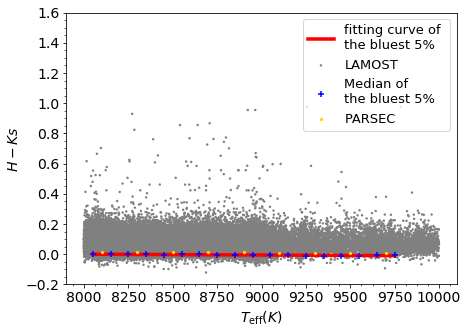

In [84]:
#PLT
ax = plt.figure(1,figsize=(7, 5))  
plt.xlabel('$T_\mathrm{eff}(K)$',fontsize=14)
plt.ylabel(ylabel,fontsize=14)

# the data we use
plt.scatter(starcatalog_fram_fil[teff], starcatalog_fram_fil[color1]-starcatalog_fram_fil[color2],\
            c='grey',s=6, alpha = 1, edgecolors='None',label='LAMOST')

# data we use in the SFD dustmap
#plt.scatter(SFD_catalog_teff,SFD_catalog_color,alpha=1,edgecolors='None',c='black',s=7,label='SFD dustmap',zorder=2)

# SFD fitcurve
#plt.plot(SFD_catalog_teff, SFD_vals, c='black',linewidth = 3.5,label='fitting curve of \nthe E(B-V)<0.05',zorder=1)

# ic plot from blue edge
plt.plot(int_teff, colorvals, c='r',linewidth = 3.5,label='fitting curve of \nthe bluest 5%',zorder=1,alpha=1)

# ic from blue edge
plt.scatter(int_teff, int_color, edgecolors='None',c='b', marker = '+',s=45,label='Median of\nthe bluest 5%',zorder=2)

# ic from Allen's work 
# plt.scatter(BBFrame_fil['Teff'],BBFrame_fil['J-H'],c='lime',s=11,label='Allen',zorder=2)

#ic from parsec
plt.scatter(parsec_teff,parsec_color,c='gold',s=5,label='PARSEC',zorder=2)
#plt.plot(parsec_teff, parsec_color, c='gold',linewidth = 3.5,label='PARSEC',zorder=1,alpha=2)
### Draw the plot

# plt.xlabel('$T_\mathrm{eff}$'); plt.ylabel(ylabel)
#plt.scatter(BBFrame_fil['Teff'],BBFrame_fil['J-H'],c='lightgreen',s=15,label='Allen')

plt.legend(loc='upper right',fontsize=13)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.minorticks_on()
#new_ticks = np.linspace(-1,2,7)
#plt.yticks(new_ticks)
#plt.ylim(-1,2)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6])
#plt.xlim(9000,25000)
#plt.savefig(savename1,dpi=200)

plt.show()

#### 